# Detección de palos en redoblante
## Introducción
Un primer paso para el análisis a partir de video de una ejecución de redoblante es la localización de los palos en la escena.

Durante la captura los palos fueron coloreados para trabajar a partir de una máscara de color que permita separarlos del resto de la imágen. 

Seguidamente se emplearon métodos con el objetivo de determinar los extremos del palo, partiendo de la base de modelarlo como un segmento en la imagen.

Finalmente a partir de la posición de dicho segmento en función del tiempo se probó un posible abordaje para determinar los instantes en los que ocurre un golpe.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
from scipy import signal
from scipy import misc
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage

import math
import time
import pdb
import os
import cv2
import skimage
from scipy.stats import norm
from scipy.spatial import distance as dist
from sklearn.mixture import GaussianMixture
from scipy.io import wavfile as wav
from scipy.signal import find_peaks

%matplotlib inline
#%matplotlib

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray' #colormap por defecto

## Máscara por color

Como mencionamos, se enmascaró un entorno de color, en este caso rojo, usando el espacio HSV. 

Las condiciones de iluminación y la posición de los interpretes se supone que no variaron lo suficiente como para afectar este factor, por lo tanto se buscaron parámetros para el entorno de rojo ajustando según uno de los videos y se espera que el resto responda del mismo modo. 

In [3]:
#ENMASCARADO DE ROJO
cap = cv2.VideoCapture('./imagenes/videos/undist_GOPR0535.MP4')

In [4]:
## Parametros de mascara
lowlimit_mask1 = (0,190,70)
uplimit_mask1 = (5,255,255)
lowlimit_mask2 = (175,190,70)
uplimit_mask2 = (180,255,255)

angles = []
PuntaL = np.array([]).reshape(0,2)
PuntaR = np.array([]).reshape(0,2)

#fondo negro
fondo=np.zeros((480,848),np.uint8)

# Punto medio
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

## Caracterización por componentes conexas
En este abordaje para la localización de los palos se etiquetaron regiones conexas de la imagen enmascarada y binarizada. 

Se hizo la suposición de que las dos regiones conexas de mayor área en la imagen corresponden a cada uno de los palos.

Luego se encontró para cada una de estas regiones el rectángulo rotado de menor área que las contuviera. 

La paralela media más larga para este rectángulo es tomada como el segmento que caracteriza al palo, buscado en esta sección. 

In [5]:
while(cap.isOpened()):
    hor_lines = []
    hor_lines_lenSq = []
    hor_lines_angle = []
    longest_hor_lines = []
    maxDistSq = 0

    ret, frame = cap.read()
    I_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    ## Mascara de rojo
    
    mask1 = cv2.inRange(I_hsv, lowlimit_mask1, uplimit_mask1)
    mask2 = cv2.inRange(I_hsv, lowlimit_mask2, uplimit_mask2)

    ## aplicacion de la mascara a la imagen
    
    mask = cv2.bitwise_or(mask1, mask2 )
    croped = cv2.bitwise_and(frame, frame, mask=mask)

    img=frame
    img = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary

    #se aplica el algorithmo de componentes conexas
    #como resultado obtendremos una imagen que numera cada pixel segun la region
    
    retval, labels = cv2.connectedComponents(img,connectivity=4)

    num = labels.max()
    
    #se miden los tamaños de todas las regiones para luego tomar las dos mayores
    
    regions_size = []
    N = 500
    for i in range(1, num+1):
        pts =  np.where(labels == i)
        regions_size.append(len(pts[0]))


    regions_size_arr = np.array(regions_size)
    sorted_regions_size_index = np.argsort(regions_size_arr)
    biggest_regions = sorted_regions_size_index[-2:]+1
    
    label0 = np.ones_like(labels)*10
    label1 = np.ones_like(labels)*10
    if biggest_regions.size != 0:
        label0[np.nonzero(np.logical_not(labels == biggest_regions[0]))] = 0
        label1[np.nonzero(np.logical_not(labels == biggest_regions[1]))] = 0
    
    # Se pintan las dos regiones elegidas
    
    label_hue = np.uint8(11*(label0+label1))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue==0] = frame[label_hue==0]

    cv2.imshow('labeled.png', labeled_img)
    
    label0 = label0.astype(np.uint8)
    
    #Se trabaja con cada una de las regiones para encontrar 
    #el rectangulo de menor area que la encierra
    
    ret,thresh0 = cv2.threshold(label0,1,num,0)
    _, contours, hierarchy = cv2.findContours(thresh0,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)# for OpenCV 3.x
    box = np.int0(box)
    cv2.drawContours(frame,[box],0,(0,0,255),2)
    orig = frame

    #se buscan los puntos medios de los lados de la caja
    (tl, tr, br, bl) = box
    (tltrX0, tltrY0) = midpoint(tl, tr)
    (blbrX0, blbrY0) = midpoint(bl, br)

    (tlblX0, tlblY0) = midpoint(tl, bl)
    (trbrX0, trbrY0) = midpoint(tr, br)

    # hallamos la distancia para determinar cual se correspone con el palo
    dA = dist.euclidean((tltrX0, tltrY0), (blbrX0, blbrY0))
    dB = dist.euclidean((tlblX0, tlblY0), (trbrX0, trbrY0))
    
    # se dibujan las lineas
    if dA>dB:
        cv2.line(orig, (int(tltrX0), int(tltrY0)), (int(blbrX0), int(blbrY0)),
            (255, 0, 255), 2)
    else:
        cv2.line(orig, (int(tlblX0), int(tlblY0)), (int(trbrX0), int(trbrY0)),
            (255, 0, 255), 2)

    #se repite el proceso para la otra region
    label1 = label1.astype(np.uint8)
    ret,thresh0 = cv2.threshold(label1,1,num,0)
    _, contours, hierarchy = cv2.findContours(thresh0,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)# for OpenCV 3.x
    box = np.int0(box)
    cv2.drawContours(frame,[box],0,(0,0,255),2)
          
    orig = frame
    (tl, tr, br, bl) = box
    (tltrX1, tltrY1) = midpoint(tl, tr)
    (blbrX1, blbrY1) = midpoint(bl, br)

    
    (tlblX1, tlblY1) = midpoint(tl, bl)
    (trbrX1, trbrY1) = midpoint(tr, br)
    
    midpoints0 = [[tltrX0, tltrY0],
                    [blbrX0, blbrY0],
                    [tlblX0, tlblY0],
                    [trbrX0, trbrY0]]
    midpoints1 = [[tltrX1, tltrY1],
                    [blbrX1, blbrY1],
                    [tlblX1, tlblY1],
                    [trbrX1, trbrY1]]
    
    mediaX0 = np.mean([tltrX0,blbrX0,tlblX0,trbrX0])
    mediaX1 = np.mean([tltrX1,blbrX1,tlblX1,trbrX1])
    
    #a partir del centro del palo se determina 
    #cual es el de la izquierda y cual el de la derecha
    if mediaX1 > mediaX0:
        iIzquierda1=np.argmin([tltrX1,blbrX1,tlblX1,trbrX1])
        PuntaR=np.append(PuntaR,[midpoints1[iIzquierda1]], axis=0)
        iDerecha0=np.argmax([tltrX0,blbrX0,tlblX0,trbrX0])
        PuntaL=np.append(PuntaL,[midpoints0[iDerecha0]], axis=0)
    else:
        iIzquierda0=np.argmin([tltrX0,blbrX0,tlblX0,trbrX0])
        PuntaR=np.append(PuntaR,[midpoints0[iIzquierda0]], axis=0)
        iDerecha1=np.argmax([tltrX1,blbrX1,tlblX1,trbrX1])
        PuntaL=np.append(PuntaL,[midpoints1[iDerecha1]], axis=0)
        
    #cv2.circle(orig, tuple(PuntaR[-1:][0].astype(np.uint8)), 5, (0,0,255), -1)
    #cv2.circle(orig, tuple(PuntaL[-1:][0].astype(np.uint8)), 5, (0,0,255), -1)

    dA = dist.euclidean((tltrX1, tltrY1), (blbrX1, blbrY1))
    dB = dist.euclidean((tlblX1, tlblY1), (trbrX1, trbrY1))
    
    # dibujamos los segmentos de interes
    if dA>dB:
        cv2.line(orig, (int(tltrX1), int(tltrY1)), (int(blbrX1), int(blbrY1)),
            (255, 0, 255), 2)
    else:
        cv2.line(orig, (int(tlblX1), int(tlblY1)), (int(trbrX1), int(trbrY1)),
            (255, 0, 255), 2)

    cv2.imshow('frame',frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

## Análisis de resultados
Para realizar un análisis cualitativo de los resultados se graficaron algunas magnitudes en paralelo con el audio de la captura.

Se tomó la posición en el eje Y de la punta del palo cómo un factor determinante en caso de pretender detectar golpes. 

Con la suposición de que un golpe es el resultado del palo rebotando contra el parche del redoblante, un cambio brusco de sentido en la velocidad del palo es lo que entendemos caraacterizará a los golpes. Por eso se halla la derivada segunda y se buscan picos de la misma. 

### Tratamiento de la señal
La señal y(t) fue filtrada con una mediana móvil de ventana w=2, lo mínimo posible, suficiente para descartar algunos glitches dispersos que se presentan en la detección de la punta del palo.

Con el fin de obtener de manera sencilla magnitudes que representen el movimiento de la punta del palo relativa al redoblante y no al frame, se hace un filtro pasa altos, para eliminar el movimiento lento que hace a la punta pegar más arriba o mas abajo en el frame. Esta información no es relevante para el abordaje de detección de golpes que estamos realizando. 

Tomaremos este video para realizar el ajuste y probaremos aplicar este algoritmo sin reajustar a un video diferente para ver los resultados. 

In [7]:
def median(lst): return np.median(np.array(lst))
def mean(lst): return sum(lst)/len(lst)

In [8]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

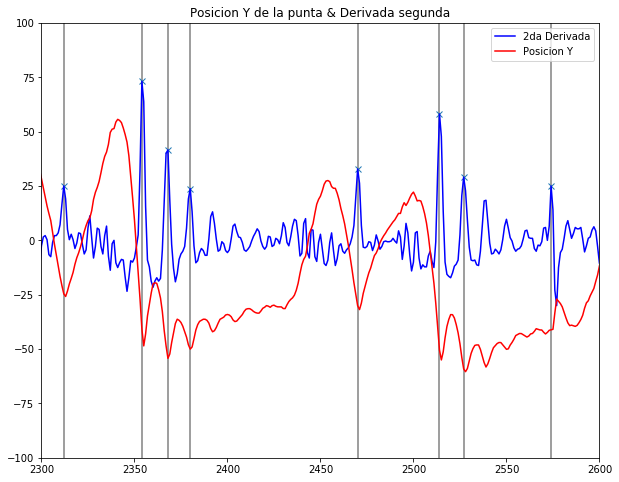

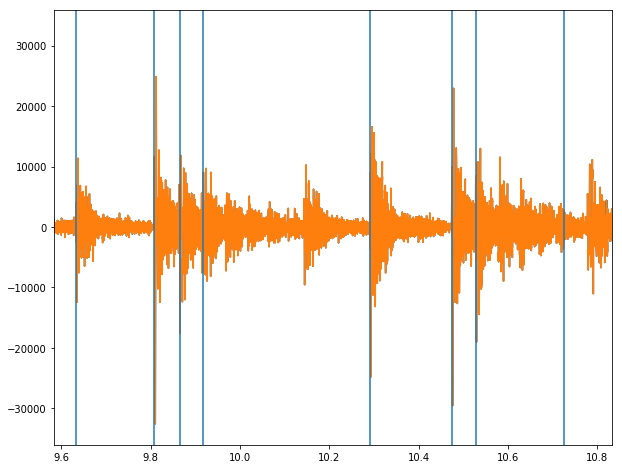

In [38]:
env = np.zeros_like(PuntaL[:,1])
w=2
N=range(len(PuntaL[:,1]))
for i in N:
    env[i] = median(PuntaL[i:i+w,1])

filtered = butter_highpass_filter(env,.3,240)
    
plt.xlim(2200,2600)

#####Derivada primera
deriv=np.gradient(env)
plt.xlim(2300,2600)
plt.ylim(-100,100)

#ploteo
#plt.figure(2)
# plt.plot(N,3*deriv)
# plt.title('Derivada')
##### 

#Derivada segunda
deriv2=np.gradient(deriv)
deriv2env = np.zeros_like(deriv2)
for i in N:
    deriv2env[i] = median(deriv2[i:i+w])
#ploteo
#plt.figure(3)
#plt.plot(N,-10*deriv2,color='g')
plt.title('Posicion Y de la punta & Derivada segunda')

from scipy.signal import find_peaks
peaks, properties=find_peaks(-10*deriv2env,prominence=9,width=1)
peaksT=22
peaksBest = peaks[np.where(-10*deriv2env[peaks]>peaksT)]
plt.plot(peaksBest,-10*deriv2env[peaksBest],"x")
plt.vlines(x=peaksBest,ymin=-4000,ymax=4000,color='grey')
plt.plot(N,-10*deriv2env,color='b',label='2da Derivada')
plt.plot(N, -filtered, color = 'r',label='Posicion Y')
plt.legend()
#plt.figure(figsize=(30,10))
plt.show()

rate, data = wav.read('./imagenes/videos/GOPR0535.wav')
Time=np.linspace(0, len(data)/rate, num=len(data))

data = np.roll(data,-4400)
plt.plot(Time,data)
plt.xlim(2300/240,2600/240)

for x in peaksBest:
    plt.axvline(x/240)
#plt.figure(figsize=(30,10))

plt.show()

## Ajuste
### Palo izquierdo
En este enfoque el único parámetro a detereminar es el umbral para considerar válido un máximo local de la aceleración. 
Observamos que para el umbral elegido tenemos un falso positivo en el fragmento mostrado, y dos golpes presentes en audio que no surgen de analizar el palo izquierdo (mirando de frente).

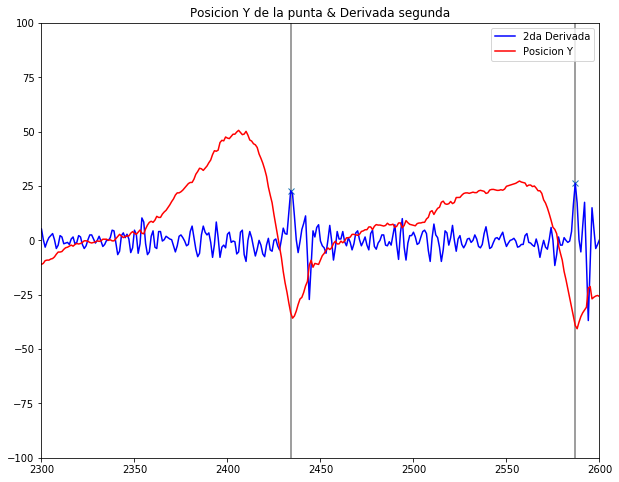

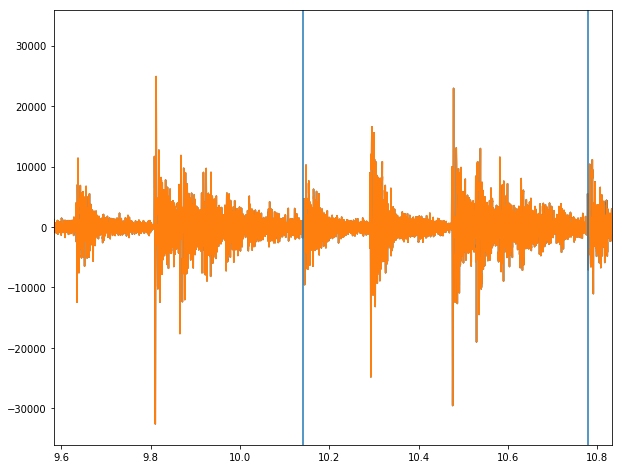

In [39]:
env = np.zeros_like(PuntaR[:,1])
w=2
N=range(len(PuntaL[:,1]))
for i in N:
    env[i] = median(PuntaR[i:i+w,1])

filtered = butter_highpass_filter(env,.3,240)
    
plt.xlim(2200,2600)

#####Derivada primera
deriv=np.gradient(env)
plt.xlim(2300,2600)
plt.ylim(-100,100)

#ploteo
#plt.figure(2)
# plt.plot(N,3*deriv)
# plt.title('Derivada')
##### 

#Derivada segunda
deriv2=np.gradient(deriv)
deriv2env = np.zeros_like(deriv2)
for i in N:
    deriv2env[i] = median(deriv2[i:i+w])
#ploteo
#plt.figure(3)
#plt.plot(N,-10*deriv2,color='g')
plt.title('Posicion Y de la punta & Derivada segunda')

from scipy.signal import find_peaks
peaks, properties=find_peaks(-10*deriv2env,prominence=9,width=1)
peaksT=22
peaksBest = peaks[np.where(-10*deriv2env[peaks]>peaksT)]
plt.plot(peaksBest,-10*deriv2env[peaksBest],"x")
plt.vlines(x=peaksBest,ymin=-4000,ymax=4000,color='grey')
plt.plot(N,-10*deriv2env,color='b',label='2da Derivada')
plt.plot(N, -filtered, color = 'r',label='Posicion Y')
plt.legend()
#plt.figure(figsize=(30,10))
plt.show()
rate, data = wav.read('./imagenes/videos/GOPR0535.wav')
Time=np.linspace(0, len(data)/rate, num=len(data))

data = np.roll(data,-4400)
plt.plot(Time,data)
plt.xlim(2300/240,2600/240)

for x in peaksBest:
    plt.axvline(x/240)
#plt.figure(figsize=(30,10))

plt.show()

### Palo derecho
Al analizar el palo derecho, manteniendo los parámetros, se detectan los dos golpes faltantes.
### Mejoras
El falso positivo en el análisis del palo izquierdo se debe a un punto silla en la aceleración. Queda pendiente la implementación de alguna heurística para diferenciarlos. 

# Test
Probaremos con un video de otro interprete para observar cualitativamente la viabilidad del modelo y la elección realizada para el parametro.

In [3]:
#ENMASCARADO DE ROJO
cap = cv2.VideoCapture('./imagenes/videos/undist_GOPR0552.MP4')

## Parametros de mascara
lowlimit_mask1 = (0,190,70)
uplimit_mask1 = (5,255,255)
lowlimit_mask2 = (175,190,70)
uplimit_mask2 = (180,255,255)

angles = []
PuntaL = np.array([]).reshape(0,2)
PuntaR = np.array([]).reshape(0,2)

#fondo negro
fondo=np.zeros((480,848),np.uint8)

# Punto medio
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

nroframe=0
while(cap.isOpened()):
    hor_lines = []
    hor_lines_lenSq = []
    hor_lines_angle = []
    longest_hor_lines = []
    maxDistSq = 0

    ret, frame = cap.read()
    I_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    nroframe+=1
    if nroframe > 5*240:
        ## Mascara de rojo

        mask1 = cv2.inRange(I_hsv, lowlimit_mask1, uplimit_mask1)
        mask2 = cv2.inRange(I_hsv, lowlimit_mask2, uplimit_mask2)

        ## aplicacion de la mascara a la imagen

        mask = cv2.bitwise_or(mask1, mask2 )
        croped = cv2.bitwise_and(frame, frame, mask=mask)

        img=frame
        img = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary

        #se aplica el algorithmo de componentes conexas
        #como resultado obtendremos una imagen que numera cada pixel segun la region

        retval, labels = cv2.connectedComponents(img,connectivity=4)

        num = labels.max()

        #se miden los tamaños de todas las regiones para luego tomar las dos mayores

        regions_size = []
        N = 500
        for i in range(1, num+1):
            pts =  np.where(labels == i)
            regions_size.append(len(pts[0]))


        regions_size_arr = np.array(regions_size)
        sorted_regions_size_index = np.argsort(regions_size_arr)
        biggest_regions = sorted_regions_size_index[-2:]+1

        label0 = np.ones_like(labels)*10
        label1 = np.ones_like(labels)*10
        if biggest_regions.size != 0:
            label0[np.nonzero(np.logical_not(labels == biggest_regions[0]))] = 0
            label1[np.nonzero(np.logical_not(labels == biggest_regions[1]))] = 0

        # Se pintan las dos regiones elegidas

        label_hue = np.uint8(11*(label0+label1))
        blank_ch = 255*np.ones_like(label_hue)
        labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
        labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
        labeled_img[label_hue==0] = frame[label_hue==0]

        cv2.imshow('labeled.png', labeled_img)

        label0 = label0.astype(np.uint8)

        #Se trabaja con cada una de las regiones para encontrar 
        #el rectangulo de menor area que la encierra

        ret,thresh0 = cv2.threshold(label0,1,num,0)
        _, contours, hierarchy = cv2.findContours(thresh0,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)# for OpenCV 3.x
        box = np.int0(box)
        cv2.drawContours(frame,[box],0,(0,0,255),2)
        orig = frame

        #se buscan los puntos medios de los lados de la caja
        (tl, tr, br, bl) = box
        (tltrX0, tltrY0) = midpoint(tl, tr)
        (blbrX0, blbrY0) = midpoint(bl, br)

        (tlblX0, tlblY0) = midpoint(tl, bl)
        (trbrX0, trbrY0) = midpoint(tr, br)

        # hallamos la distancia para determinar cual se correspone con el palo
        dA = dist.euclidean((tltrX0, tltrY0), (blbrX0, blbrY0))
        dB = dist.euclidean((tlblX0, tlblY0), (trbrX0, trbrY0))

        # se dibujan las lineas
        if dA>dB:
            cv2.line(orig, (int(tltrX0), int(tltrY0)), (int(blbrX0), int(blbrY0)),
                (255, 0, 255), 2)
        else:
            cv2.line(orig, (int(tlblX0), int(tlblY0)), (int(trbrX0), int(trbrY0)),
                (255, 0, 255), 2)

        #se repite el proceso para la otra region
        label1 = label1.astype(np.uint8)
        ret,thresh0 = cv2.threshold(label1,1,num,0)
        _, contours, hierarchy = cv2.findContours(thresh0,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)# for OpenCV 3.x
        box = np.int0(box)
        cv2.drawContours(frame,[box],0,(0,0,255),2)

        orig = frame
        (tl, tr, br, bl) = box
        (tltrX1, tltrY1) = midpoint(tl, tr)
        (blbrX1, blbrY1) = midpoint(bl, br)


        (tlblX1, tlblY1) = midpoint(tl, bl)
        (trbrX1, trbrY1) = midpoint(tr, br)

        midpoints0 = [[tltrX0, tltrY0],
                        [blbrX0, blbrY0],
                        [tlblX0, tlblY0],
                        [trbrX0, trbrY0]]
        midpoints1 = [[tltrX1, tltrY1],
                        [blbrX1, blbrY1],
                        [tlblX1, tlblY1],
                        [trbrX1, trbrY1]]

        mediaX0 = np.mean([tltrX0,blbrX0,tlblX0,trbrX0])
        mediaX1 = np.mean([tltrX1,blbrX1,tlblX1,trbrX1])

        #a partir del centro del palo se determina 
        #cual es el de la izquierda y cual el de la derecha
        if mediaX1 > mediaX0:
            iIzquierda1=np.argmin([tltrX1,blbrX1,tlblX1,trbrX1])
            PuntaR=np.append(PuntaR,[midpoints1[iIzquierda1]], axis=0)
            iDerecha0=np.argmax([tltrX0,blbrX0,tlblX0,trbrX0])
            PuntaL=np.append(PuntaL,[midpoints0[iDerecha0]], axis=0)
        else:
            iIzquierda0=np.argmin([tltrX0,blbrX0,tlblX0,trbrX0])
            PuntaR=np.append(PuntaR,[midpoints0[iIzquierda0]], axis=0)
            iDerecha1=np.argmax([tltrX1,blbrX1,tlblX1,trbrX1])
            PuntaL=np.append(PuntaL,[midpoints1[iDerecha1]], axis=0)

        #cv2.circle(orig, tuple(PuntaR[-1:][0].astype(np.uint8)), 5, (0,0,255), -1)
        #cv2.circle(orig, tuple(PuntaL[-1:][0].astype(np.uint8)), 5, (0,0,255), -1)

        dA = dist.euclidean((tltrX1, tltrY1), (blbrX1, blbrY1))
        dB = dist.euclidean((tlblX1, tlblY1), (trbrX1, trbrY1))

        # dibujamos los segmentos de interes
        if dA>dB:
            cv2.line(orig, (int(tltrX1), int(tltrY1)), (int(blbrX1), int(blbrY1)),
                (255, 0, 255), 2)
        else:
            cv2.line(orig, (int(tlblX1), int(tlblY1)), (int(trbrX1), int(trbrY1)),
                (255, 0, 255), 2)

        cv2.imshow('frame',frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

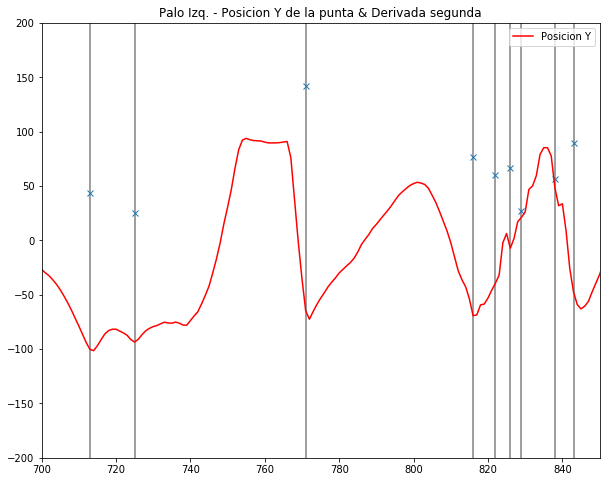

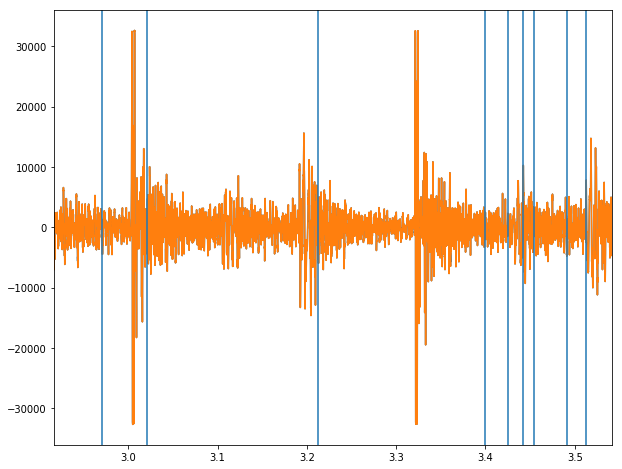

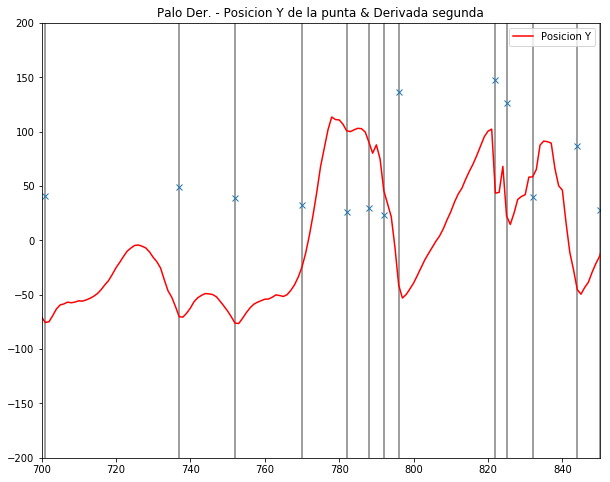

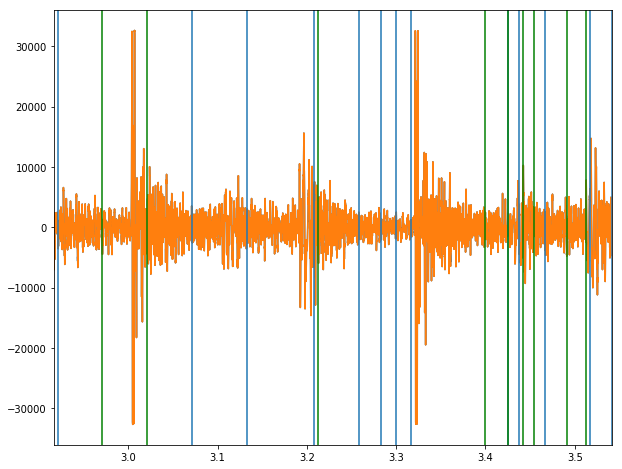

In [39]:
def median(lst): return np.median(np.array(lst))
def mean(lst): return sum(lst)/len(lst)

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

offset = 52
ylim = 200

env = np.zeros_like(PuntaL[:,1])
w=2
N=range(len(PuntaL[:,1]))
for i in N:
    env[i] = median(PuntaL[i:i+w,1])

filtered = butter_highpass_filter(env,.3,240)
xlim2 = 850#len(N)
xlim1 = 700#1400#xlim2 - 200

plt.xlim(xlim1,xlim2)

#####Derivada primera
deriv=np.gradient(env)
#plt.xlim(2300,2600)
plt.ylim(-ylim,ylim)

#ploteo
#plt.figure(2)
# plt.plot(N,3*deriv)
# plt.title('Derivada')
##### 

#Derivada segunda
deriv2=np.gradient(deriv)
deriv2env = np.zeros_like(deriv2)
for i in N:
    deriv2env[i] = median(deriv2[i:i+w])
#ploteo
#plt.figure(3)
#plt.plot(N,-10*deriv2,color='g')
plt.title('Palo Izq. - Posicion Y de la punta & Derivada segunda')

from scipy.signal import find_peaks
peaks, properties=find_peaks(-10*deriv2env,prominence=9,width=1)
peaksT=22
peaksBest1 = peaks[np.where(-10*deriv2env[peaks]>peaksT)]
plt.plot(peaksBest1,-10*deriv2env[peaksBest1],"x")
plt.vlines(x=peaksBest1,ymin=-4000,ymax=4000,color='grey')
#plt.plot(N,-10*deriv2env,color='b',label='2da Derivada')
plt.plot(N, -filtered, color = 'r',label='Posicion Y')
plt.legend()
#plt.figure(figsize=(30,10))
plt.show()

rate, data = wav.read('./imagenes/videos/GOPR0552.wav')
Time=np.linspace(0, len(data)/rate, num=len(data))

data = np.roll(data,int(-4410*offset))
plt.plot(Time,data)
plt.xlim(xlim1/240,xlim2/240)

for x in peaksBest1:
    plt.axvline(x/240)
#plt.figure(figsize=(30,10))

plt.show()

env = np.zeros_like(PuntaR[:,1])
w=2
N=range(len(PuntaL[:,1]))
for i in N:
    env[i] = median(PuntaR[i:i+w,1])

filtered = butter_highpass_filter(env,.3,240)
    
plt.xlim(xlim1,xlim2)

#####Derivada primera
deriv=np.gradient(env)
#plt.xlim(2300,2600)
plt.ylim(-ylim,ylim)

#ploteo
#plt.figure(2)
# plt.plot(N,3*deriv)
# plt.title('Derivada')
##### 

#Derivada segunda
deriv2=np.gradient(deriv)
deriv2env = np.zeros_like(deriv2)
for i in N:
    deriv2env[i] = median(deriv2[i:i+w])
#ploteo
#plt.figure(3)
#plt.plot(N,-10*deriv2,color='g')
plt.title('Palo Der. - Posicion Y de la punta & Derivada segunda')

from scipy.signal import find_peaks
peaks, properties=find_peaks(-10*deriv2env,prominence=9,width=1)
peaksT=22
peaksBest = peaks[np.where(-10*deriv2env[peaks]>peaksT)]
plt.plot(peaksBest,-10*deriv2env[peaksBest],"x")
plt.vlines(x=peaksBest,ymin=-4000,ymax=4000,color='grey')
#plt.plot(N,-10*deriv2env,color='b',label='2da Derivada')
plt.plot(N, -filtered, color = 'r',label='Posicion Y')
plt.legend()
#plt.figure(figsize=(30,10))
plt.show()
rate, data = wav.read('./imagenes/videos/GOPR0552.wav')
Time=np.linspace(0, len(data)/rate, num=len(data))

data = np.roll(data,int(-4410*offset))
plt.plot(Time,data)
plt.xlim(xlim1/240,xlim2/240)

for x in peaksBest:
    plt.axvline(x/240)
for x in peaksBest1:
    plt.axvline(x/240,color='g')
#plt.figure(figsize=(30,10))

plt.show()